In [3]:
from cnn_on import CustomDataset, ConvertToRGB, Strategie
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from PIL import Image
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader, Dataset, random_split
import csv
from torchvision.models import resnet18
import json
from torch.utils.data import Subset

In [27]:
def dataset_load(test_path):
    """
    Dataset loader

    Parameters:
    --------------------------------
    test_path : str
        paths for each image in the test set
    Return:
    --------------------------------
    testloader:
        return the testloader for the test set
    """
    
    with open(test_path, "r") as f:
        lines = f.readlines()

    # Créer des listes pour stocker les chemins d'image et les étiquettes
    image_paths_test = []
    labels_test = []

    # Parcourir chaque ligne du fichier texte et extraire les informations
    for line in lines:
        line = line.strip().split(" ")
        if line[1] == "0" or line[1] == "1":
            image_paths_test.append("test/" + line[0])
            labels_test.append(int(line[1]))
            
    # Appliquer les transformations d'image si nécessaire
    transformation = transforms.Compose(
        [
            ConvertToRGB(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

    df_test = CustomDataset(image_paths_test, labels_test, transform=transformation)
    test_dataset_size = len(df_test)
    split_sizes = [test_dataset_size // 2, test_dataset_size - test_dataset_size // 2]
    test_online, test_dataset = random_split(df_test, split_sizes)

    # ...

# Assumons que vous voulez diviser les images de chaque classe équitablement entre test_online et test_dataset
# C'est-à-dire, 1250 images de chaque classe pour test_online si possible.

    desired_online_images = 2500
    desired_online_per_class = desired_online_images // 2  # 1250 pour chaque classe

    labels_one_hot = [df_test[i][1] for i in range(len(df_test))]
    labels_classes = [torch.argmax(label).item() for label in labels_one_hot]

    indices_class_0 = [i for i, label in enumerate(labels_classes) if label == 0]
    indices_class_1 = [i for i, label in enumerate(labels_classes) if label == 1]

    # Obtenez les indices pour test_online en prenant le min entre la taille réelle de la classe et le nombre souhaité
    split_point_0 = min(desired_online_per_class, len(indices_class_0))
    split_point_1 = min(desired_online_per_class, len(indices_class_1))

    indices_online = indices_class_0[:split_point_0] + indices_class_1[:split_point_1]
    indices_dataset = indices_class_0[split_point_0:] + indices_class_1[split_point_1:]

    test_online = Subset(df_test, indices_online)
    test_dataset = Subset(df_test, indices_dataset)

    online_loader = DataLoader(test_online, batch_size = 1, shuffle=False)
    testloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

    return testloader, online_loader


In [28]:
test, online = dataset_load(os.path.join('./', "test/image_list.txt"))

In [25]:
counter = [0,0]
liste = []
for images, labels in online:
    liste.append(torch.argmax(labels, dim = 1).item())
    counter[torch.argmax(labels, dim = 1)] += 1
print(counter)

[1250, 1250]


In [26]:
print(liste)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

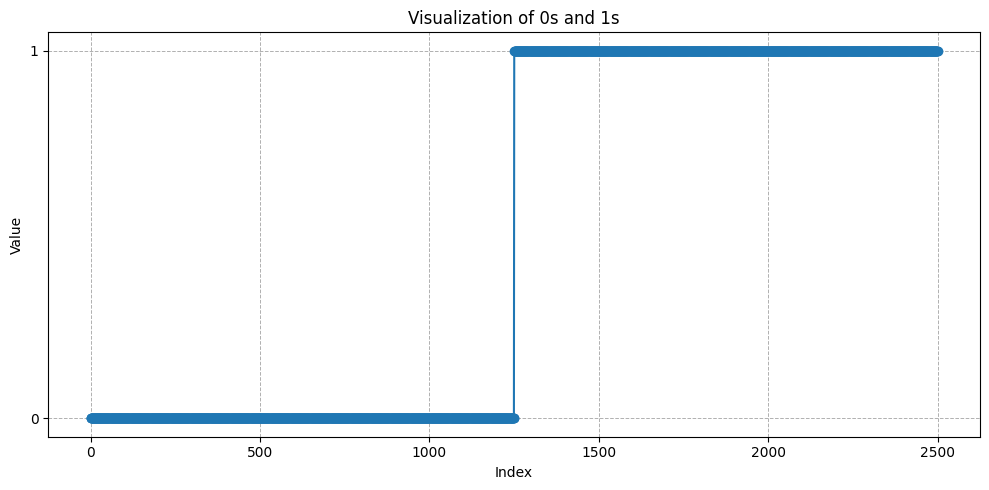

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(liste, 'o-')
plt.yticks([0, 1])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Visualization of 0s and 1s')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


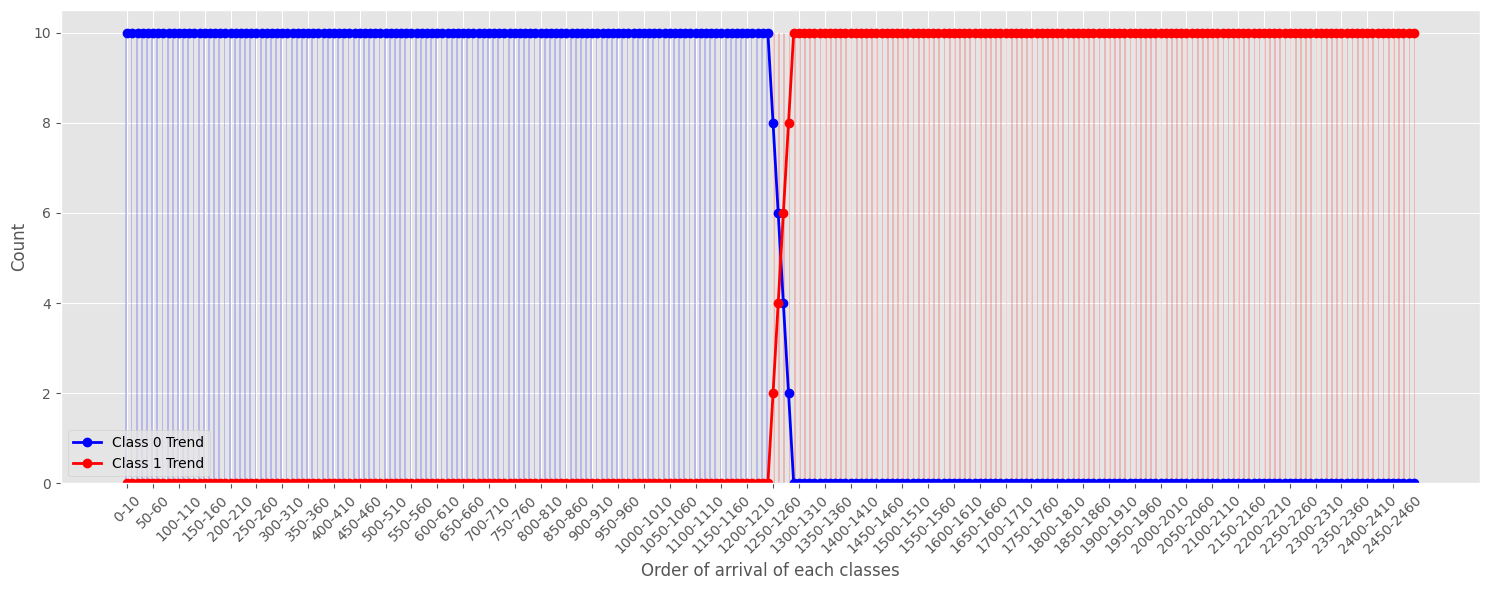

In [29]:
import matplotlib.pyplot as plt
import numpy as np

labels_list = []

# Extraire les indices des classes à partir du dataloader
for _, labels in online:
    for label in labels:
        labels_list.append(torch.argmax(label).item())

# Nous n'avons plus besoin d'extraction supplémentaire, donc nous supprimons l'étape d'extraction
class_indices = labels_list

# Diviser les données en blocs de 10
blocks = [class_indices[i:i+10] for i in range(0, len(class_indices), 10)]

# Compter les occurrences de chaque classe dans chaque bloc
counts = [(block.count(0), block.count(1)) for block in blocks]

# Préparation des données pour le traçage
class_0_counts = [count[0] for count in counts]
class_1_counts = [count[1] for count in counts]

# ... [Reste du code pour le traçage]


def moving_average(data, window_size):
    """Compute the moving average of a list."""
    cumsum = [0]
    moving_avgs = []

    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=window_size:
            moving_avg = (cumsum[i] - cumsum[i-window_size]) / window_size
            moving_avgs.append(moving_avg)

    # Pad the beginning with the first value to make it the same length as data
    return [data[0]] * (window_size - 1) + moving_avgs

# Apply moving average
window_size = 5
smoothed_class_0 = moving_average(class_0_counts, window_size)
smoothed_class_1 = moving_average(class_1_counts, window_size)

# Plotting
plt.style.use("ggplot")
plt.figure(figsize=(15,6))

# Bar positions
bar_locations = np.arange(len(counts))
bar_width = 0.35


# Plot bars for each class with very low opacity
plt.bar(bar_locations, class_0_counts, bar_width, color='blue', alpha=0.2)
plt.bar(bar_locations + bar_width, class_1_counts, bar_width, color='red', alpha=0.2)

# Plot smoothed trend lines for each class
plt.plot(bar_locations + bar_width / 2, smoothed_class_0, color='blue', marker='o', linestyle='-', linewidth=2, label='Class 0 Trend')
plt.plot(bar_locations + bar_width / 2, smoothed_class_1, color='red', marker='o', linestyle='-', linewidth=2, label='Class 1 Trend')

# Labeling and display adjustments
plt.xlabel('Order of arrival of each classes')
plt.ylabel('Count')

# Set x-ticks every 50 epochs (or every 5 blocks since each block is 10 data points)
plt.xticks(bar_locations[::5] + bar_width / 2, (str(i*10) + '-' + str((i+1)*10) for i in range(0, len(counts), 5)), rotation=45)

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
import os

# Charger le dataset
filepath = os.path.join('result_online', os.path.join('cnn_50_0.001_SGD', "test_accuracy_per_repetition"))
data = pd.read_csv(filepath)

# Supprimer la colonne "Epoch" car nous n'en avons pas besoin pour calculer la moyenne et la variance
data['Mean'] = data.iloc[:, 1:].mean(axis=1, skipna=True)
data['Variance'] = data.iloc[:, 1:-1].var(axis=1, skipna=True)

print(data[['Epoch', 'Mean', 'Variance']])

     Epoch       Mean  Variance
0        0  55.798193  0.000000
1        1  55.750502  0.000032
2        2  55.798193  0.000000
3        3  55.798193  0.000000
4        4  55.798193  0.000000
..     ...        ...       ...
148    148  55.798193  0.000000
149    149  55.798193  0.000000
150    150  55.798193  0.000000
151    151  55.798193  0.000000
152    152  55.798193  0.000000

[153 rows x 3 columns]


In [39]:
filepath = os.path.join('result_online', os.path.join('cnn_50_0.001_SGD', "test_loss_per_repetition"))
dataa = pd.read_csv(filepath)

# Supprimer la colonne "Epoch" car nous n'en avons pas besoin pour calculer la moyenne et la variance
dataa['Mean'] = dataa.iloc[:, 1:].mean(axis=1, skipna=True)
dataa['Variance'] = dataa.iloc[:, 1:-1].var(axis=1, skipna=True)

print(dataa[['Epoch', 'Mean', 'Variance']])

     Epoch      Mean      Variance
0        0  0.781822  5.362589e-09
1        1  0.715801  7.756973e-09
2        2  0.693705  3.708690e-09
3        3  0.687252  9.973167e-09
4        4  0.685792  1.926381e-08
..     ...       ...           ...
148    148  0.940277  2.289073e-05
149    149  0.941197  2.499164e-05
150    150  0.940614  1.325399e-05
151    151  0.941302  1.471809e-05
152    152  0.940192  1.514084e-05

[153 rows x 3 columns]


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_graph_2(name, object1, label_one, object2, label_two, std_dev1=None, std_dev2=None, ylabel_loss=True, yl = None):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 5))
    #plt.title(name)
    
    plt.plot(object1, label=label_one)
    if std_dev1 is not None:
        plt.fill_between(range(len(object1)), [m - d for m, d in zip(object1, std_dev1)], [m + d for m, d in zip(object1, std_dev1)], alpha=0.2)
    
    plt.plot(object2, label=label_two)
    if std_dev2 is not None:
        plt.fill_between(range(len(object2)), [m - d for m, d in zip(object2, std_dev2)], [m + d for m, d in zip(object2, std_dev2)], alpha=0.2)
    
    plt.xlabel("Epochs")
    if ylabel_loss:
        plt.ylabel("Loss")
    else:
        plt.ylabel("Accuracy")
    if yl is not None:
        plt.ylim(40, yl)
    plt.legend()
    plt.show()

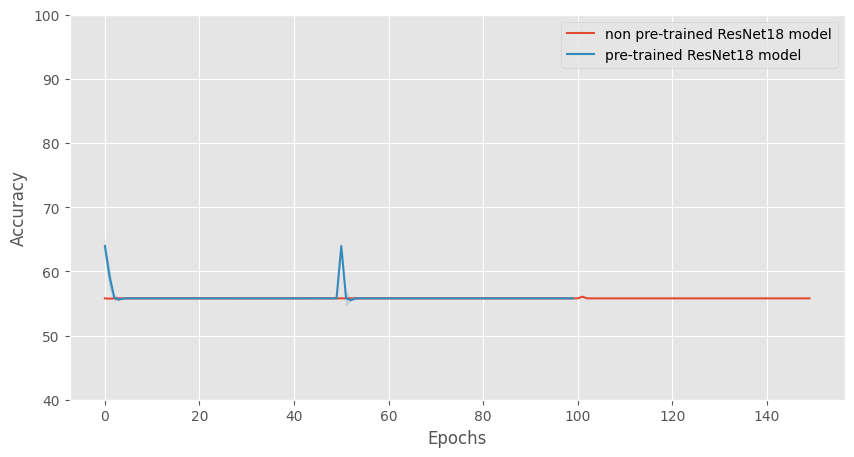

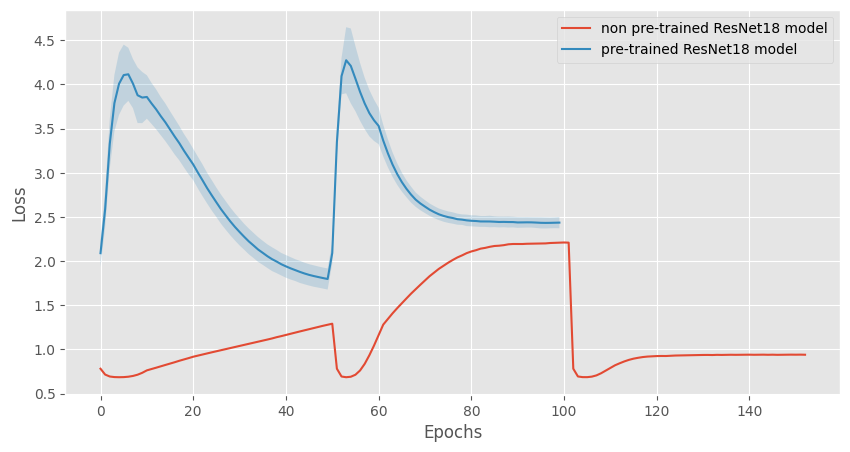

In [47]:
df = data
std = data['Variance']
df_path = os.path.join('result_online','cnn_50_0.001_SGD_pt')
df_p = pd.read_csv(os.path.join(df_path,'average_loss_and_accuracy'))
std_p = pd.read_csv(os.path.join(df_path,'std_loss_and_accuracy'))

# Suppression des lignes pour df
rows_to_delete = [i for i in range(50, len(df), 51)]
df = df.drop(rows_to_delete).reset_index(drop=True)

#Suppression des lignes pour df_p
rows_to_delete_p = [i for i in range(50, len(df_p), 51)]
df_p = df_p.drop(rows_to_delete_p).reset_index(drop=True)

plot_graph_2(name ="Accuracy over Epochs",
            object1=df['Mean'],
            object2=df_p['Val Accuracy'],
            label_one='non pre-trained ResNet18 model',
            label_two='pre-trained ResNet18 model',
            std_dev1= std,
            std_dev2= std_p['Val Accuracy'],
            ylabel_loss=False,
            yl = 100
            )
plot_graph_2(name ="Loss over Epochs",
            object1=dataa['Mean'],
            object2=df_p['Val Loss'],
            label_one='non pre-trained ResNet18 model',
            label_two='pre-trained ResNet18 model',
            std_dev1= dataa['Variance'],
            std_dev2= std_p['Val Loss'],
            ylabel_loss=True,
            #yl = 7
            )